Import dados

In [1]:
#Pandas: #
from asyncore import read
import pandas as pd

#Matplotlib: #
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sympy import *
from sympy.abc import theta
from scipy.optimize import curve_fit

#Atropy: #
from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file
from astropy.wcs import WCS

# Scatter density (Para os gráficos)#

import mpl_scatter_density
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

Importação do arquivo

In [2]:
print("Parametros ultilizados no site do Gaia \n 1- Distances less than 500 pc; \n 2- Glatitudes less than 2° in module; \n 3- Parallax errors less than 2%; \n 4- Proper motion errors less than 2%;")
print("\n")
print(" SELECT ra, dec, parallax, l, b, pm, pmra, pmdec \n FROM gaiaedr3.gaia_source \n WHERE parallax < 500 AND abs(b) < 2 AND ABS ( parallax_error/parallax ) < 2 AND ABS( pmra_error/pmra ) < 0.02 AND ABS ( pmdec_error/pmdec ) < 0.02")

Parametros ultilizados no site do Gaia 
 1- Distances less than 500 pc; 
 2- Glatitudes less than 2° in module; 
 3- Parallax errors less than 2%; 
 4- Proper motion errors less than 2%;


 SELECT ra, dec, parallax, l, b, pm, pmra, pmdec 
 FROM gaiaedr3.gaia_source 
 WHERE parallax < 500 AND abs(b) < 2 AND ABS ( parallax_error/parallax ) < 2 AND ABS( pmra_error/pmra ) < 0.02 AND ABS ( pmdec_error/pmdec ) < 0.02


In [3]:
gaia= pd.read_csv('./1649112049535O-result.csv', encoding='ISO-8859-1')
#Calcular a distancia, mudando para pc#
gaia['range'] = 1000/(gaia['parallax'])
gaia

,ra,dec,parallax,l,b,pm,pmra,pmdec,range
0,285.455926,5.698511,2.511152,39.185344,0.295548,11.044467,8.495857,-7.056959,398.223639
1,285.491975,5.703664,5.687639,39.206346,0.266016,78.955700,61.732914,49.224494,175.819871
2,285.490436,5.722492,3.792153,39.222384,0.275997,65.405210,4.451024,-65.253586,263.702411
3,285.509115,5.758464,2.678990,39.262874,0.275941,19.226456,6.898079,-17.946395,373.274972
4,285.418511,5.736569,6.910620,39.202142,0.346068,80.779580,58.735853,55.456650,144.704808
...,...,...,...,...,...,...,...,...,...
471848,189.384786,-61.529015,2.844176,301.275846,1.298036,64.940900,-63.586325,-13.194718,351.595684
471849,189.474388,-61.515465,2.492590,301.317798,1.313841,34.091780,-19.773537,-27.771510,401.189064
471850,189.610278,-61.472204,2.726219,301.380354,1.360385,28.307728,-27.602000,6.281486,366.808390
471851,189.481348,-61.475924,2.288782,301.319039,1.353502,5.448966,3.460638,-4.208944,436.913520


Coordenadas equatoriais (ra,dec )

Text(0.5, 1.0, 'Coordenadas Equatoriais')

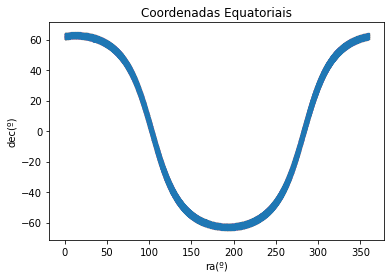

In [4]:
plt.scatter(gaia['ra'], gaia['dec'], s=0.002)
plt.xlabel('ra(º)')
plt.ylabel('dec(º)')
plt.title('Coordenadas Equatoriais')


Coordenadas Galácticas (l, b) 

([<matplotlib.axis.YTick at 0x225117f90d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

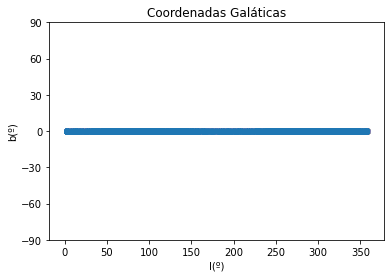

In [5]:
plt.scatter(gaia['l'], gaia['b'], s=0.002)
plt.xlabel('l(º)')
plt.ylabel('b(º)')
plt.title('Coordenadas Galáticas')
plt.yticks(np.arange(-90, 120, 30))

Coordenadas retangulares heliocêntricas (x, y)

Text(0, 0.5, 'y(pc)')

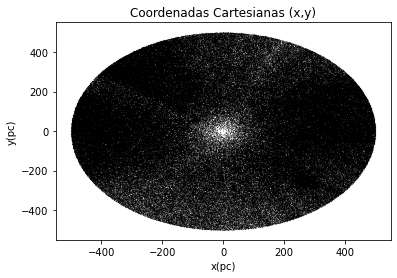

In [7]:
x = gaia['range'] * np.cos(np.radians(gaia['b'])) * np.sin(np.radians(gaia['l']))
y = gaia['range'] * np.cos(np.radians(gaia['b'])) * np.cos(np.radians(gaia['l']))

plt.scatter(x, y, color='black',  s=0.005)
plt.title('Coordenadas Cartesianas (x,y)')
plt.xlabel('x(pc)')
plt.ylabel('y(pc)')


Coordenadas retangulares heliocêntricas (x, z)

Text(0, 0.5, 'z(pc)')

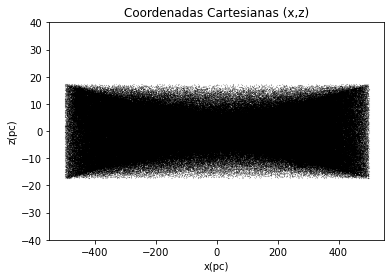

In [37]:
x = gaia['range'] * np.cos(np.radians(gaia['b'])) * np.sin(np.radians(gaia['l']))
z = gaia['range'] * np.sin(np.radians(gaia['b']))

plt.scatter(x, z, color='black', s=0.005)
plt.yticks(np.arange(-40, 50, 10))
plt.title('Coordenadas Cartesianas (x,z)')
plt.xlabel('x(pc)')
plt.ylabel('z(pc)')



Transforme o movimento próprio de coordenadas equatoriais para coordenadas Galácticas.

In [38]:
# Para  fazer isto é necessário selecionar uma amostra de estrela nas proximidades do sistema solar, ou seja, até 100 pc de nós, então: #
distancia_100pc = gaia.loc[gaia['range']<100]
distancia_100pc = distancia_100pc.reset_index()

#Coordenadas equatoriais -> coordenadas galácticas#
# Ascensão reta (ra) = alpha #
alpha = np.radians(192.85948)
# Declinação (dec) = delta #
delta = np.radians(27.12825)

# Calculando a rotação
c1 = np.sin(delta)*np.cos(np.radians(distancia_100pc['dec'])) - np.cos(delta)*np.sin(np.radians(distancia_100pc['dec']))*np.cos(np.radians(distancia_100pc['ra']) - alpha)
c2 = np.cos(delta)*np.sin(np.radians(distancia_100pc['ra']) - alpha)
cosb = np.sqrt(c1**2 + c2**2)

# Ajustando o sistema de coordenadas galácticas (l,b): #
pm_l = 1/cosb * (c1*distancia_100pc['pmra'] + c2*distancia_100pc['pmdec'])
pm_b = 1/cosb * (-c2*distancia_100pc['pmra'] + c1*distancia_100pc['pmdec'])

# Calculando a velocidade transversal #
vt = pm_l*distancia_100pc['range']*4.74047 / (np.cos(np.radians(distancia_100pc['b']))*1000)
vt

0      -23.120896
1      -67.653911
2      -23.207167
3       13.613115
4      -78.497548
          ...    
9691   -58.502782
9692   -59.435547
9693    20.605727
9694   -66.780246
9695   -24.904302
Length: 9696, dtype: float64

Plote um gráfico de Vt(l) para as estrelas muito próximas do Sol. Ajuste uma função para
obter a velocidade do Sol (v0, v0) relativa ao LSR.

Text(0, 0.5, 'vt (km s$^{-1})$')

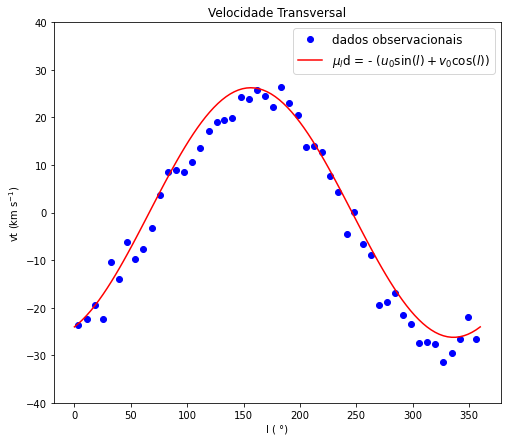

In [39]:
variacao = 7.2
l1 = 0
l2 = variacao

# Declarando matrizes : #
lsample = []
vtsample = []

l = np.array(distancia_100pc['l'])

while l2 <= 360:
    cond = np.argwhere( (l>l1) & (l<l2) ).flatten()
    
    lsample.append(np.mean((distancia_100pc['l'])[cond]))
    vtsample.append(np.mean(vt[cond]))
    
    l1 = l2
    l2 = l2 + variacao


def func(l, u0, v0):
    return -(u0*np.sin(np.radians(l)) + v0*np.cos(np.radians(l)))   


params, cov = curve_fit(func, lsample, vtsample)
u0   = params[0]
v0   = params[1]

# Parametros x e y: #
xfit = np.linspace(0,360,100)
yfit = func(xfit, u0, v0)


#Gráfico: #

fig, ax = plt.subplots(figsize = (8,7))
#Dados observacionais: #
plt.plot(lsample, vtsample, 'o', label='dados observacionais', color='blue')
# Movimento próprio:#
plt.plot(xfit, yfit, label='$\mu_l$d = - ($u_0 \sin(l) + v_0 \cos(l)$)', color='red')



plt.yticks(np.arange(-40, 50, 10))

plt.title('Velocidade Transversal')
plt.legend(fontsize=12)
plt.xlabel('l ( °)')
plt.ylabel('vt (km s$^{-1})$')


 Plote os movimentos próprios em longitude, já corrigidos pela velocidade do Sol. Ajuste
uma função para obter A e B

In [40]:
# Agora ao invês de definir a distancia de 100 pc, vamos ultilizar todos os dados importados do arquivo do gaia #

# Constantes definidas $Poleski$
alpha = np.radians(192.85948)
delta = np.radians(27.12825)

# Matriz de rotação
c1 = np.sin(delta)*np.cos(np.radians(gaia['dec'])) - np.cos(delta)*np.sin(np.radians(gaia['dec']))*np.cos(np.radians(gaia['ra']) - alpha)
c2 = np.cos(delta)*np.sin(np.radians(gaia['ra']) - alpha)
cosb = np.sqrt(c1**2 + c2**2)

# Tranformando o movimento próprio para coordenadas apropriadas "l"
mp_l_estrela = 1/cosb * (c1*gaia['pmra'] + c2*gaia['pmdec'])


# Cálculo do movimento próprio real #
correcao = 1000*(u0*np.sin(np.radians(gaia['l'])) + v0*np.cos(np.radians(gaia['l'])))/gaia['range']
mpl = mp_l_estrela*4.74047/np.cos(np.radians(gaia['b'])) + correcao

# Variação
l1 = 0
l2 = 7.2

lsample = []
mplsample = []


l = np.array(gaia['l'])

while l2 <= 360:
    cond = np.argwhere( (l>l1) & (l<l2) ).flatten()
    
    lsample.append(np.mean(l[cond]))
    mplsample.append(np.mean(mpl[cond]))
    
    l1 = l2
    l2 = l2 + 7.2


def func(l, A, B):
    return A*np.cos(2*np.radians(l)) + B  

# Achando as constantes:
params, cov = curve_fit(func, lsample, mplsample)

A   = params[0]
B   = params[1]

print('A = %lf' %(A))
print('B = %lf' %(B))




A = 18.511743
B = -16.665400


Commbine A e B para obter a velocidade angular do Sol. Supondo que R0 = 8 kpc já é conhecido, calcule a velocidade circular do Sol e a massa interna ao círculo solar.


Text(0, 0.5, '$\\mu_l$ (km s$^{-1}$ kpc$^{-1}$)')

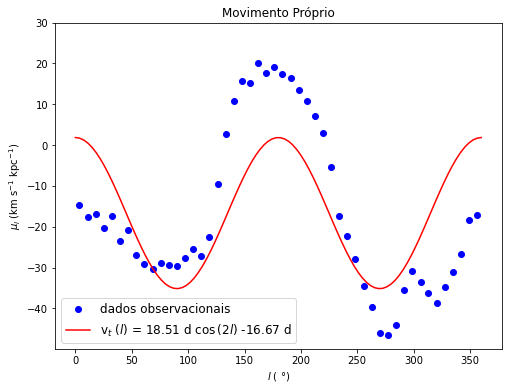

In [41]:
# Parametros (x,y)
xfit = np.linspace(0,360,100)
yfit = func(xfit, A, B)

#Gráfico:
fig, ax = plt.subplots(figsize=(8,6))

#Dados observacionais: #
plt.plot(lsample, mplsample, 'o', label='dados observacionais', color='blue')
#Dados plotados da velocidade circular do Sol: #
plt.plot(xfit, yfit, label=f'v$_t$ ($l$) = {np.around(A,2)} d $\cos$(2$l$) {np.around(B,2)} d', color='red')


plt.yticks(np.arange(-40, 40, 10))
plt.title('Movimento Próprio')
plt.legend(fontsize=12)
plt.xlabel('$l$ ( °)')
plt.ylabel('$\mu_l$ (km s$^{-1}$ kpc$^{-1}$)')
